Task1

Perceptron Accuracy: 1.00


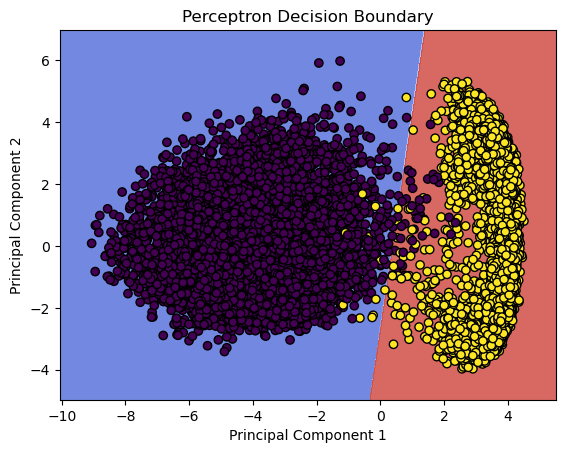

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = fetch_openml('mnist_784', version=1, as_frame=False)
features, labels = data.data, data.target

binary_digits = (labels == '0') | (labels == '1')
features, labels = features[binary_digits], labels[binary_digits]
labels = labels.astype(int)

features = features / 255.0

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)
perceptron_model = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron_model.fit(features_train, labels_train)

predicted_labels = perceptron_model.predict(features_test)
accuracy = accuracy_score(labels_test, predicted_labels)
print(f"Perceptron Accuracy: {accuracy:.2f}")

pca_model = PCA(n_components=2)
features_train_pca = pca_model.fit_transform(features_train)

def visualize_decision_boundary(X, y, model, pca_transform):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.predict(pca_transform.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='viridis')
    plt.title("Perceptron Decision Boundary")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

visualize_decision_boundary(features_train_pca, labels_train, perceptron_model, pca_model)


In [2]:
# Limitations of the Perceptron Model on High-Dimensional Data 

# While the perceptron is effective for simple datasets, its linearity, lack of flexibility, and inability to handle
# high-dimensional, non-linear relationships make it unsuitable for complex datasets.
# Perceptrons fail to converge if the dataset is not linearly separable.
# The perceptron struggles with data that is not linearly separable
# Advanced models such as logistic regression, support vector machines (SVMs), or neural networks are better suited for such tasks.

Task2

In [10]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import time

dataset = fetch_openml('CIFAR_10_small', version=1, as_frame=False)
features, targets = dataset.data, dataset.target.astype(int)

features = features / 255.0
encoded_targets = OneHotEncoder(sparse_output=False).fit_transform(targets.reshape(-1, 1))
features_train, features_test, targets_train, targets_test = train_test_split(features, encoded_targets, test_size=0.2, random_state=42)

def activate_sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_gradient(x): return x * (1 - x)

def activate_relu(x): return np.maximum(0, x)
def relu_gradient(x): return (x > 0).astype(float)

def activate_tanh(x): return np.tanh(x)
def tanh_gradient(x): return 1 - np.tanh(x) ** 2

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation_function="relu"):
        self.layer1_weights = np.random.randn(input_size, hidden_size) * 0.01
        self.layer1_biases = np.zeros((1, hidden_size))
        self.layer2_weights = np.random.randn(hidden_size, output_size) * 0.01
        self.layer2_biases = np.zeros((1, output_size))
        self.activation_function = activation_function
        if activation_function == "sigmoid":
            self.activation = activate_sigmoid
            self.gradient = sigmoid_gradient
        elif activation_function == "relu":
            self.activation = activate_relu
            self.gradient = relu_gradient
        elif activation_function == "tanh":
            self.activation = activate_tanh
            self.gradient = tanh_gradient
    
    def forward_pass(self, X):
        self.layer1_output = np.dot(X, self.layer1_weights) + self.layer1_biases
        self.activated_layer1 = self.activation(self.layer1_output)
        self.layer2_output = np.dot(self.activated_layer1, self.layer2_weights) + self.layer2_biases
        self.final_output = activate_sigmoid(self.layer2_output)
        return self.final_output
    
    def backward_pass(self, X, y, predictions):
        samples_count = X.shape[0]
        error_final_output = predictions - y
        layer2_weight_gradient = np.dot(self.activated_layer1.T, error_final_output) / samples_count
        layer2_bias_gradient = np.sum(error_final_output, axis=0, keepdims=True) / samples_count
        error_layer1 = np.dot(error_final_output, self.layer2_weights.T)
        gradient_layer1 = error_layer1 * self.gradient(self.activated_layer1)
        layer1_weight_gradient = np.dot(X.T, gradient_layer1) / samples_count
        layer1_bias_gradient = np.sum(gradient_layer1, axis=0, keepdims=True) / samples_count
        self.layer1_weights -= 0.1 * layer1_weight_gradient
        self.layer1_biases -= 0.1 * layer1_bias_gradient
        self.layer2_weights -= 0.1 * layer2_weight_gradient
        self.layer2_biases -= 0.1 * layer2_bias_gradient
    
    def train_network(self, X, y, iterations):
        start = time.time()
        for iteration in range(iterations):
            predictions = self.forward_pass(X)
            self.backward_pass(X, y, predictions)
        print(f"Training Time: {time.time() - start:.2f} seconds")
    
    def predict(self, X):
        predictions = self.forward_pass(X)
        return np.argmax(predictions, axis=1)

for func in ["relu", "sigmoid", "tanh"]:
    print(f"\nTraining using {func} activation function:")
    network = NeuralNetwork(input_size=3072, hidden_size=64, output_size=10, activation_function=func)
    network.train_network(features_train, targets_train, iterations=50)
    predictions = network.predict(features_test)
    test_accuracy = accuracy_score(np.argmax(targets_test, axis=1), predictions)
    print(f"Accuracy using {func}: {test_accuracy:.2f}")



Training using relu activation function:
Training Time: 10.76 seconds
Accuracy using relu: 0.10

Training using sigmoid activation function:
Training Time: 11.39 seconds
Accuracy using sigmoid: 0.10

Training using tanh activation function:
Training Time: 12.53 seconds
Accuracy using tanh: 0.18


Task3

In [4]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

categories = [
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.electronics',
    'sci.med',
    'talk.politics.mideast',
    'talk.politics.misc'
]

dataset = fetch_20newsgroups(subset='all', categories=categories)
texts, targets = dataset.data, dataset.target
class_names = dataset.target_names

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_features = vectorizer.fit_transform(texts)

class BalancedNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.prior_probs = np.zeros(len(self.classes))
        self.conditional_probs = np.zeros((len(self.classes), X.shape[1]))

        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            self.prior_probs[idx] = X_cls.shape[0] / X.shape[0]
            self.conditional_probs[idx, :] = (X_cls.sum(axis=0) + 1) / (X_cls.sum() + X.shape[1])

    def predict(self, X):
        log_prior = np.log(self.prior_probs)
        log_likelihood = X @ np.log(self.conditional_probs.T)
        return np.argmax(log_prior + log_likelihood, axis=1)

X_train, X_test, y_train, y_test = train_test_split(tfidf_features, targets, test_size=0.2, random_state=42)
model = BalancedNaiveBayes()
model.fit(X_train.toarray(), y_train)
predicted_labels = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Final Accuracy: {accuracy:.2f}")
print(classification_report(y_test, predicted_labels, target_names=class_names))


Final Accuracy: 0.96
                       precision    recall  f1-score   support

   rec.sport.baseball       0.96      0.97      0.97       216
     rec.sport.hockey       0.94      0.98      0.96       187
      sci.electronics       0.93      0.97      0.95       195
              sci.med       0.96      0.92      0.94       196
talk.politics.mideast       0.98      0.98      0.98       190
   talk.politics.misc       0.98      0.92      0.95       153

             accuracy                           0.96      1137
            macro avg       0.96      0.96      0.96      1137
         weighted avg       0.96      0.96      0.96      1137



Task4

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 7))
for i in np.unique(y_train):
    plt.scatter(X_train_pca_2d[y_train == i, 0], X_train_pca_2d[y_train == i, 1], label=f"Class {i}", alpha=0.6)
plt.title("PCA : Clusters Formed by Classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

components_list = [10, 50, 100, 200, 784]
reconstruction_errors = []

for n_components in components_list:
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train_scaled)
    X_train_reconstructed = pca.inverse_transform(X_train_reduced)
    mse = mean_squared_error(X_train_scaled, X_train_reconstructed)
    reconstruction_errors.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(components_list, reconstruction_errors, marker='o',color='b')
plt.title("Reconstruction Error vs Number of Components")
plt.ylabel("Mean Squared Error (Reconstruction)")
plt.xlabel("Count of Principal Components")
plt.grid()
plt.show()


Task5

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

(X_train, y_train), _ = fashion_mnist.load_data()
X_train_flat = X_train.reshape(X_train.shape[0], -1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)

pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

linkage_matrix = linkage(X_train_pca_2d, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

cluster_model = AgglomerativeClustering(n_clusters=10, linkage='ward')
clusters = cluster_model.fit_predict(X_train_pca_2d)
silhouette = silhouette_score(X_train_pca_2d, clusters)

plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title("Agglomerative Clustering (2D PCA Projection)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

components_list = [10, 50, 100, 200, 784]
reconstruction_errors = []

for n_components in components_list:
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train_scaled)
    X_train_reconstructed = pca.inverse_transform(X_train_reduced)
    mse = mean_squared_error(X_train_scaled, X_train_reconstructed)
    reconstruction_errors.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(components_list, reconstruction_errors, marker='o')
plt.title("Reconstruction Error vs Number of Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Squared Error (Reconstruction)")
plt.grid()
plt.show()

print(f"Silhouette Score for Agglomerative Clustering: {silhouette:.4f}")
